Saved: project_level_eda_kd.csv


,n_charts,EDS_mean,EDS_max,interaction_max,EDS_project,XPS_mean_from_charts,narrative_bonus,XPS_project,any_annotation,any_result_title,any_summary,any_conclusion,EDS_norm,XPS_norm,class_label
website,,,,,,,,,,,,,,,
https://ahsanv101.github.io/ProjectGaze/,13,1.153846,5,3,4.153846,0.153846,2,2.153846,1,0,1,0,0.511848,0.430769,Hybrid
https://alessandrafa.github.io/buerkel-photos/index.html,11,0.727273,4,2,2.727273,0.363636,4,4.363636,1,0,0,1,0.336062,0.872727,KD
https://alicebordignon.github.io/ITArtHistorians/index.html,14,1.571429,5,3,4.571429,0.142857,4,4.142857,1,0,0,1,0.563304,0.828571,Hybrid
https://alicepicco333.github.io/culture4all/,5,3.200000,4,2,5.200000,0.000000,4,4.000000,0,0,0,1,0.640758,0.800000,Hybrid
https://aschimmenti.github.io/humansOfZeriPhotoArchive,7,1.571429,4,3,4.571429,0.000000,2,2.000000,0,0,1,0,0.563304,0.400000,EDA
https://baizhankyzy.github.io/female-directors/,5,1.000000,4,2,3.000000,0.200000,4,4.200000,1,0,0,1,0.369668,0.840000,KD
https://dbrembilla.github.io/redditholes/,26,5.115385,6,3,8.115385,0.000000,4,4.000000,0,0,0,1,1.000000,0.800000,Hybrid
https://digitalstory33.github.io/RENAIScience/index.html,9,1.777778,6,3,4.777778,0.000000,0,0.000000,0,0,0,0,0.588731,0.000000,EDA
https://elisasilvad.github.io/the_journey_of_art/,12,1.833333,5,3,4.833333,0.416667,0,0.416667,1,1,0,0,0.595577,0.083333,EDA


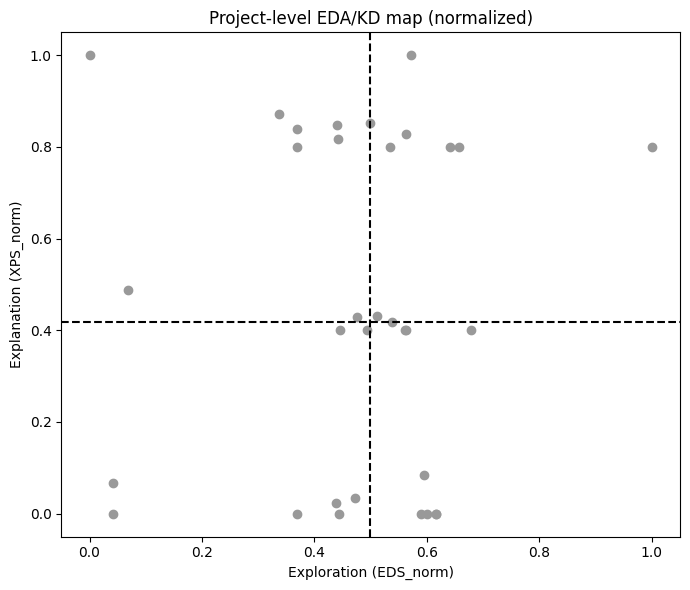

In [1]:
# === Project-level EDA/KD classification (with normalization) ================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

PATH_IN  = "website_structure_with_interactions_derived.csv"
PATH_OUT = "project_level_eda_kd.csv"

# -------------------- Load + light lowercase copies for filtering ------------
df = pd.read_csv(PATH_IN)
df["type_str"] = df["type"].astype(str).str.lower().str.strip()
df["role_str"] = df["role"].astype(str).str.lower().str.strip()
df["chart_title_type_str"] = df.get("chart_title_type", pd.Series(index=df.index)).astype(str).str.lower().str.strip()

is_chart = df["type_str"].str.contains("chart", na=False)
is_text  = df["type_str"].str.contains("text",  na=False)

# -------------------- Helpers -------------------------------------------------
def split_tokens(s):
    """Split feature strings into normalized tokens (lowercased)."""
    if not isinstance(s, str):
        return []
    return [t for t in re.split(r"[,\|\;]\s*|\s+", s.lower().strip()) if t]

def flexible_focus(features):
    """
    Focus flexibility:
      strong (2): filters, search, zoom, find-more, view-change
      weak   (1): hover, click, metadata, on-demand, flip, broken-y
      none   (0): else
    """
    toks = set(split_tokens(features))
    strong = {"filters", "filter", "search", "zoom", "find-more", "view-change"}
    weak   = {"hover", "click", "metadata", "on-demand", "flip", "broken-y"}
    if toks & strong: return 2
    if toks & weak:   return 1
    return 0

def interpretation_score(annotations):
    """Chart-level explanation via in-chart annotations."""
    return 1 if isinstance(annotations, str) and annotations.strip() else 0

def title_explanation_score(title_type_str):
    """Chart title framing: 'result' -> 1, else 0."""
    return 1 if isinstance(title_type_str, str) and title_type_str == "result" else 0

def multi_view_flag(rep):
    """Multiple related views → exploration boost."""
    return 1 if isinstance(rep, str) and rep.strip().lower() == "yes" else 0

def minmax(s: pd.Series) -> pd.Series:
    """Simple min–max normalization to [0,1]; returns zeros if constant."""
    smin, smax = s.min(), s.max()
    rng = smax - smin
    return (s - smin) / rng if rng else s*0

# -------------------- CHART-LEVEL: EDS and XPS components --------------------
charts = df[is_chart].copy()

# EDS components
charts["interaction_level_filled"] = charts["interaction_level"].fillna(0)
charts["flex_focus"] = charts["chart_interaction_feature"].apply(flexible_focus)
charts["multi_view"] = charts["repetition"].apply(multi_view_flag)
charts["EDS_chart"]  = charts["interaction_level_filled"] + charts["flex_focus"] + charts["multi_view"]

# XPS chart-level = annotations + result-oriented title (no sequence)
charts["interpretation"]    = charts["chart_annotations"].apply(interpretation_score)
charts["title_explanation"] = charts["chart_title_type_str"].apply(title_explanation_score)
charts["XPS_chart"]         = charts["interpretation"] + charts["title_explanation"]

# -------------------- TEXT-LEVEL: narrative flags per website ----------------
texts = df[is_text].copy()
summary_by_site    = texts.groupby("website", dropna=False)["role_str"].apply(lambda s: int((s == "summary").any()))
conclusion_by_site = texts.groupby("website", dropna=False)["role_str"].apply(lambda s: int((s == "conclusion").any()))

# -------------------- PROJECT-LEVEL aggregation ------------------------------
g = charts.groupby("website", dropna=False)

proj = pd.DataFrame({
    "n_charts":             g.size(),
    "EDS_mean":             g["EDS_chart"].mean(),
    "EDS_max":              g["EDS_chart"].max(),
    "interaction_max":      g["interaction_level_filled"].max(),
    "XPS_mean_from_charts": g["XPS_chart"].mean(),
    "any_annotation":       g["interpretation"].max(),
    "any_result_title":     g["title_explanation"].max(),
})

# attach narrative flags (from TEXT rows)
proj = proj.join(summary_by_site.rename("any_summary"), how="left")
proj = proj.join(conclusion_by_site.rename("any_conclusion"), how="left")
proj[["any_summary","any_conclusion"]] = proj[["any_summary","any_conclusion"]].fillna(0).astype(int)

# Compose raw project scores (keep these for reference/CSV)
proj["EDS_project"] = proj["EDS_mean"] + proj["interaction_max"]

SUMMARY_BONUS, CONCLUSION_BONUS = 2, 4  # moderate gap
proj["narrative_bonus"] = np.where(
    proj["any_conclusion"] == 1, CONCLUSION_BONUS,
    np.where(proj["any_summary"] == 1, SUMMARY_BONUS, 0)
)
proj["XPS_project"] = proj["XPS_mean_from_charts"] + proj["narrative_bonus"]

# -------------------- NORMALIZATION (project-level only) ---------------------
proj["EDS_norm"] = minmax(proj["EDS_project"])
proj["XPS_norm"] = minmax(proj["XPS_project"])

# Classify using normalized axes (balanced quadrants)
eds_thr = proj["EDS_norm"].median()
xps_thr = proj["XPS_norm"].median()

def classify_row(eds_n, xps_n, e_t, x_t):
    if eds_n >= e_t and xps_n <  x_t: return "EDA"
    if eds_n <  e_t and xps_n >= x_t: return "KD"
    if eds_n >= e_t and xps_n >= x_t: return "Hybrid"
    return "Descriptive"

proj["class_label"] = proj.apply(lambda r: classify_row(r["EDS_norm"], r["XPS_norm"], eds_thr, xps_thr), axis=1)

# -------------------- Save + quick peek --------------------------------------
cols = [
    # diagnostics / raw
    "n_charts",
    "EDS_mean","EDS_max","interaction_max","EDS_project",
    "XPS_mean_from_charts","narrative_bonus","XPS_project",
    "any_annotation","any_result_title","any_summary","any_conclusion",
    # normalized + class
    "EDS_norm","XPS_norm","class_label"
]
proj = proj[cols]
proj.to_csv(PATH_OUT, index=True, encoding="utf-8-sig")
print(f"Saved: {PATH_OUT}")
display(proj.head(10))

# -------------------- Optional scatter (normalized axes) ---------------------
plt.figure(figsize=(7,6))
plt.scatter(proj["EDS_norm"], proj["XPS_norm"], color="#999999")
plt.axvline(eds_thr, linestyle="--", color="black")
plt.axhline(xps_thr, linestyle="--", color="black")
plt.xlabel("Exploration (EDS_norm)")
plt.ylabel("Explanation (XPS_norm)")
plt.title("Project-level EDA/KD map (normalized)")
plt.tight_layout()
plt.savefig('imgs/scatter_project_eds_xps_normalized.png')
plt.show()


In [2]:
# Ensure 'website' is the index on both frames
if proj.index.name != "website":
    proj = proj.copy()
    proj.index.name = "website"

meta = pd.read_csv("records.csv")

def count_sources_semicolon(s):
    """
    Count semicolon-separated data sources in a project-level field.
    Handles NaN, empty strings, irregular spacing, and trailing semicolons.
    """
    # Handle missing values
    if pd.isna(s):
        return 0

    # Convert to string and strip outer whitespace
    s = str(s).strip()

    # Empty string → zero sources
    if s == "":
        return 0

    # Split on semicolon
    parts = s.split(";")
    return len(parts)


# Count semicolon-separated sources per project
meta["n_sources_meta"] = meta["data_source"].apply(count_sources_semicolon)
meta = meta.set_index("website")

# --- Safest: assign by mapping (avoids join + overlapping columns) ----------
proj["n_sources"] = proj.index.map(meta["n_sources_meta"])




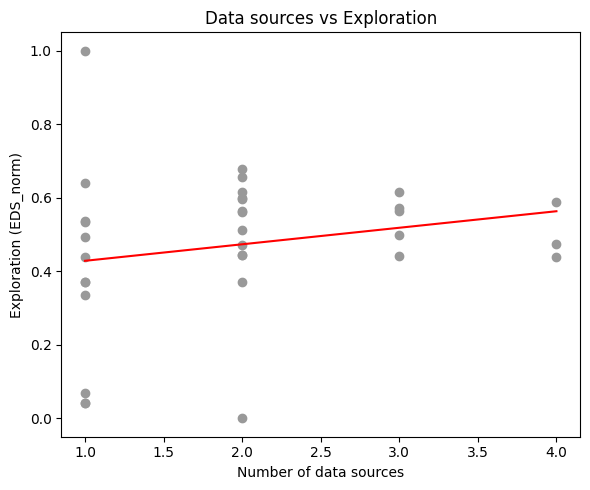

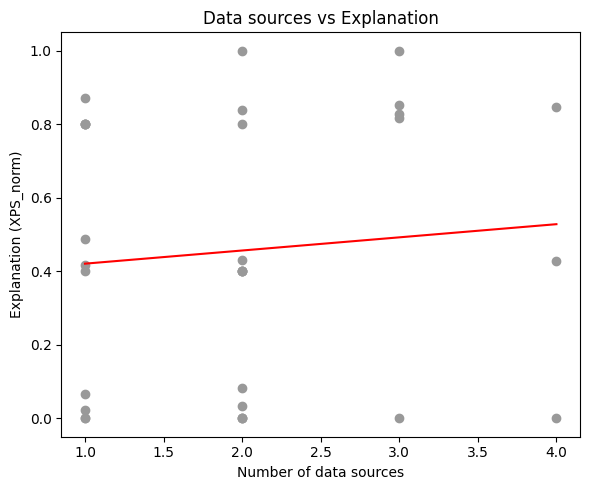

In [3]:
plt.figure(figsize=(6,5))
plt.scatter(proj["n_sources"], proj["EDS_norm"], color="#999999")
m, b = np.polyfit(proj["n_sources"], proj["EDS_norm"], 1)
xx = np.linspace(proj["n_sources"].min(), proj["n_sources"].max(), 100)
plt.plot(xx, m*xx + b, color='red')
plt.xlabel("Number of data sources")
plt.ylabel("Exploration (EDS_norm)")
plt.title("Data sources vs Exploration")
plt.tight_layout()
plt.savefig('imgs/data_sources_vs_exploration.png')
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(proj["n_sources"], proj["XPS_norm"], color="#999999")
m, b = np.polyfit(proj["n_sources"], proj["XPS_norm"], 1)
xx = np.linspace(proj["n_sources"].min(), proj["n_sources"].max(), 100)
plt.plot(xx, m*xx + b, color='red')
plt.xlabel("Number of data sources")
plt.ylabel("Explanation (XPS_norm)")
plt.title("Data sources vs Explanation")
plt.tight_layout()
plt.savefig('imgs/data_sources_vs_explanation.png')
plt.show()


In [9]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# === EDS Project-level correlations ===
x_eds = proj["n_sources"]
y_eds = proj["EDS_norm"]

eds_pearson, eds_pearson_p = pearsonr(x_eds, y_eds)
eds_spearman, eds_spearman_p = spearmanr(x_eds, y_eds)
eds_kendall, eds_kendall_p = kendalltau(x_eds, y_eds)

print("=== EDS correlations ===")
print(f"Pearson r = {eds_pearson:.3f} (p={eds_pearson_p:.3f})")
print(f"Spearman ρ = {eds_spearman:.3f} (p={eds_spearman_p:.3f})")
print(f"Kendall τ = {eds_kendall:.3f} (p={eds_kendall_p:.3f})")


# === XPS Project-level correlations ===
x_xps = proj["n_sources"]
y_xps = proj["XPS_norm"]

xps_pearson, xps_pearson_p = pearsonr(x_xps, y_xps)
xps_spearman, xps_spearman_p = spearmanr(x_xps, y_xps)
xps_kendall, xps_kendall_p = kendalltau(x_xps, y_xps)

print("\n=== XPS correlations ===")
print(f"Pearson r   = {xps_pearson:.3f} (p={xps_pearson_p})")
print(f"Spearman ρ  = {xps_spearman:.3f} (p={xps_spearman_p})")
print(f"Kendall τ   = {xps_kendall:.3f} (p={xps_kendall_p})")




=== EDS correlations ===
Pearson r = 0.210 (p=0.241)
Spearman ρ = 0.270 (p=0.128)
Kendall τ = 0.193 (p=0.160)

=== XPS correlations ===
Pearson r   = 0.094 (p=0.6035044722955427)
Spearman ρ  = 0.129 (p=0.47446949092152524)
Kendall τ   = 0.092 (p=0.5157483745081886)
